In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)
vix_values = vix_data['VIX'].values.reshape(-1, 1)

scaler = MinMaxScaler()
vix_values_scaled = scaler.fit_transform(vix_values)
train_dataset = tf.data.Dataset.from_tensor_slices(vix_values_scaled).shuffle(len(vix_values_scaled)).batch(32)


In [ ]:

# Define the generator model with condition
def make_generator_model():
    noise_input = layers.Input(shape=(100,))
    condition_input = layers.Input(shape=(1,))
    x = layers.concatenate([noise_input, condition_input])
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(1024, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(1, activation='linear')(x)  #Linear activation function
    model = tf.keras.Model([noise_input, condition_input], x)
    return model

# Define the critic model
def make_critic_model():
    data_input = layers.Input(shape=(1,))
    condition_input = layers.Input(shape=(1,))
    x = layers.concatenate([data_input, condition_input])
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1)(x)  # No activation
    model = tf.keras.Model([data_input, condition_input], x)
    return model


In [ ]:

# Initialize models
generator = make_generator_model()
critic = make_critic_model()

# Optimizers
critic_optimizer = tf.keras.optimizers.RMSprop(5e-5)
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)


In [ ]:

# Define loss functions
def critic_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# Training step with dynamic condition adjustment
def train_step(real_data, condition):
    batch_size = real_data.shape[0]  # Determine the dynamic batch size
    noise = tf.random.normal([batch_size, 100])  # Adjust noise to match batch size

    # Dynamically adjust the condition to match the current batch size
    condition_batch = tf.repeat(condition, repeats=batch_size, axis=0)

    # Train Critic
    with tf.GradientTape() as critic_tape:
        generated_data = generator([noise, condition_batch], training=True)
        real_output = critic([real_data, condition_batch], training=True)
        fake_output = critic([generated_data, condition_batch], training=True)
        c_loss = critic_loss(real_output, fake_output)

    critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))

    # Train Generator
    with tf.GradientTape() as gen_tape:
        generated_data = generator([noise, condition_batch], training=True)
        fake_output = critic([generated_data, condition_batch], training=True)
        g_loss = generator_loss(fake_output)

    generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return real_data, generated_data, g_loss, c_loss

Epoch 1, Gen Loss: 0.1393618881702423, Disc Loss: -0.07503236085176468, Metric Diff: 0.10279147719797499
Epoch 2, Gen Loss: 0.1720687448978424, Disc Loss: -0.11397449672222137, Metric Diff: -0.0638259833509027
Epoch 3, Gen Loss: 0.22396695613861084, Disc Loss: -0.1598399579524994, Metric Diff: -0.023808453028827836
Epoch 4, Gen Loss: 0.2809181213378906, Disc Loss: -0.2215171754360199, Metric Diff: -0.0018345897847711345
Epoch 5, Gen Loss: 0.3748120665550232, Disc Loss: -0.302132785320282, Metric Diff: -0.00023827308955781668
Epoch 6, Gen Loss: 0.5154365301132202, Disc Loss: -0.4441746771335602, Metric Diff: -0.0024356430226861736
Epoch 7, Gen Loss: 0.6247432827949524, Disc Loss: -0.5573909878730774, Metric Diff: -0.015102956240802934
Epoch 8, Gen Loss: 0.7829564213752747, Disc Loss: -0.7258308529853821, Metric Diff: -0.002132478898197343
Epoch 9, Gen Loss: 1.0004327297210693, Disc Loss: -0.934735119342804, Metric Diff: -0.040080208128124406
Epoch 10, Gen Loss: 1.1095194816589355, Disc 

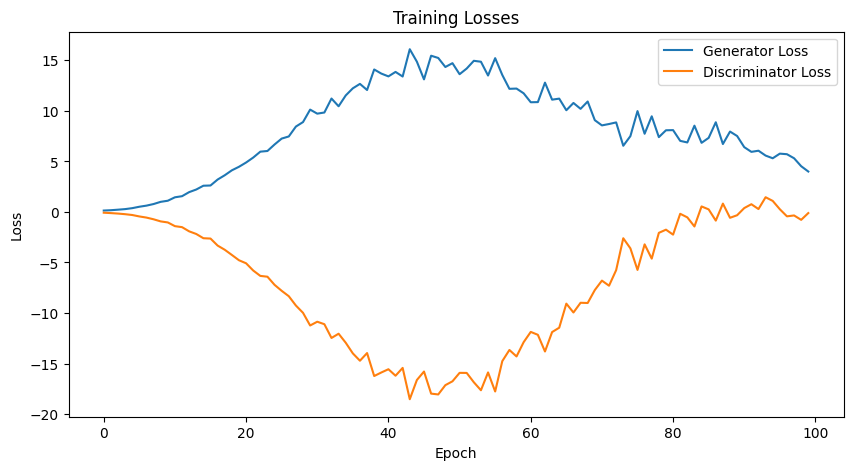

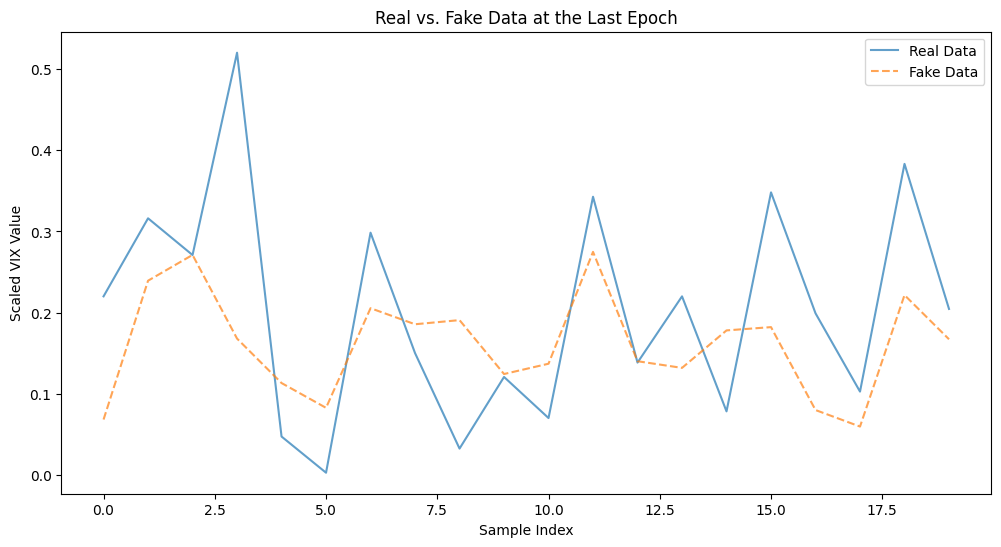

Mean Differences per Epoch: [0.10279147719797499, -0.0638259833509027, -0.023808453028827836, -0.0018345897847711345, -0.00023827308955781668, -0.0024356430226861736, -0.015102956240802934, -0.002132478898197343, -0.040080208128124406, -0.01125513369384401, -0.03144176656547182, -0.0003646498376428109, -0.017897445505291126, -0.025124270265728166, -0.011860299652248524, 0.02202584987339387, -0.0038509851152002117, -0.013056713884502552, -0.008369985764652421, -0.006212729757457902, -0.009529758041530778, 0.005083974654048751, -0.024295616691738325, -0.009206864779621265, 0.007900741154521773, -0.021054390614658525, -0.0004304235631524822, -0.01938782984557741, -0.0023578142577706795, 0.006533425504535506, 0.0009412581270635823, -0.0017967706376611492, -0.007791641896396806, 0.0009720737284124314, -0.004555064981609486, -0.0027272438460885784, 0.0016598517244756916, 0.0023659730499685505, -0.01196726018729799, -0.0001084541732370159, 0.0010058844631612995, -0.0064117645675240975, -0.004

In [ ]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training function with loss plotting
def train(dataset, epochs, condition):
    gen_losses = []
    disc_losses = []
    metric_diff = []

    for epoch in range(epochs):
        epoch_gen_losses = []
        epoch_disc_losses = []
        real_samples = []
        fake_samples = []

        for real_data in dataset:
            real_data, generated_data, gen_loss, disc_loss = train_step(real_data, condition)
            real_samples.extend(real_data.numpy())
            fake_samples.extend(generated_data.numpy())
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

        gen_losses.append(np.mean(epoch_gen_losses))
        disc_losses.append(np.mean(epoch_disc_losses))
        metric_diff.append(np.mean(real_samples) - np.mean(fake_samples))

        print(f"Epoch {epoch+1}, Gen Loss: {gen_losses[-1]}, Disc Loss: {disc_losses[-1]}, Metric Diff: {metric_diff[-1]}")

    # Plotting generator and discriminator losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting real vs. fake data comparison
    display_start_index = 0  # Start index of the sample to display
    display_end_index = 20  # End index of the sample to display

    plt.figure(figsize=(12, 6))
    plt.plot(real_samples[display_start_index:display_end_index], label='Real Data', alpha=0.7)
    plt.plot(fake_samples[display_start_index:display_end_index], label='Fake Data', alpha=0.7, linestyle='--')
    plt.title('Real vs. Fake Data at the Last Epoch')
    plt.xlabel('Sample Index')
    plt.ylabel('Scaled VIX Value')
    plt.legend()
    plt.show()

    return metric_diff

# Define the condition for the cGAN
condition_value = 0.5

# Train the model
metric_difference = train(train_dataset, epochs=100, condition=tf.constant([[condition_value]]))
print("Mean Differences per Epoch:", metric_difference)